In [32]:
# imports
import requests # to request raw data from website
from bs4 import BeautifulSoup # to parse data and identify key elements we want
import pandas as pd # to analyze data
import numpy as np # to analyze data
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

In [12]:
# request website data
# lists for DataFrame
season_number_list = []
episode_number_list = []
episode_title_list = []
episode_airdate_list = []
episode_rating_list = []
episode_votes_list = []
episode_description_list = []

for season in range(6): # to iterate through each season
    season_number = season + 1

    #print(f'>>PARSING SEASON {season_number}')

    # step 1: isolate individual episode tiles from site
    url = f"https://www.imdb.com/title/tt1942683/episodes?season={season_number}"
    response = requests.get(url)
    season_page = BeautifulSoup(response.content, 'lxml')
    episode_tiles = season_page.findAll("div", attrs={"class":"info"}) # is stored as a list

    # step 2: isolate relevant data from each episode tile
    # want episode title, air date, rating, and number of votes
    # episode_tile data is stored in a list. need to parse through every item in that list
    for episode_number, episode in enumerate(episode_tiles): #iterates through elements of list and gives indexes of list

        season_number_list.append(season_number)
        episode_number_list.append(episode_number + 1)

        # episode title
        episode_title = episode.strong.a.text
        #print(f'episode_title: {episode_title}')
        episode_title_list.append(episode_title)

        # air date
        episode_airdate = episode.find("div", attrs={"class":"airdate"}).text.strip().replace(".", "")
        #print(f'episode_airdate: {episode_airdate}')
        episode_airdate_list.append(episode_airdate)

        # rating
        episode_rating = episode.find(
            #"div", attrs={"class":"ipl-rating-widget"}).find(
            #"div", attrs={"class":"ipl-rating-star small"}).find(
            "span", attrs={"class":"ipl-rating-star__rating"}).text
        #print(f'episode_rating: {episode_rating}')
        episode_rating_list.append(episode_rating)

        # number of votes
        episode_votes = episode.find(
            #"div", attrs={"class":"ipl-rating-widget"}).find(
            #"div", attrs={"class":"ipl-rating-star small"}).find(
            "span", attrs={"class":"ipl-rating-star__total-votes"}).text.strip("()")
        #print(f'episode_votes: {episode_votes}')
        episode_votes_list.append(episode_votes)

        episode_description = episode.find(
            "div", attrs={"class": "item_description"}).text.strip()
        #print(f'episode_description: {episode_description}\n')
        episode_description_list.append(episode_description)



# putting data into a table

In [14]:
# dataframe
# will allow us to put data into a table using lists/columns
dataFrame = pd.DataFrame({
    "season_number": season_number_list,
    "episode_number": episode_number_list,
    "episode_title": episode_title_list,
    "episode_airdate": episode_airdate_list,
    "episode_rating": episode_rating_list,
    "episode_votes": episode_votes_list,
    "episode_description": episode_description_list
})


# covert episode_airdate, episode_rating, and episode_votes to proper format for data analysis
dataFrame['episode_airdate'] = pd.to_datetime(dataFrame['episode_airdate'])
dataFrame['episode_rating'] = dataFrame['episode_rating'].astype(float)
dataFrame['episode_votes'] = dataFrame['episode_votes'].astype(int)
                               

# creating graphs using episode ratings

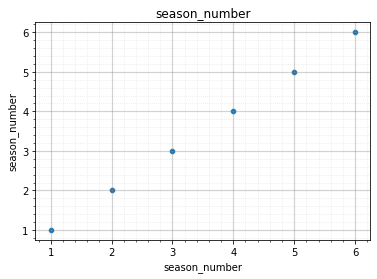

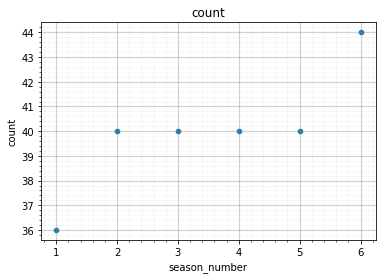

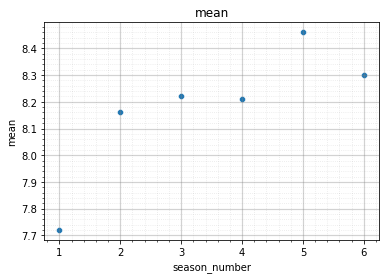

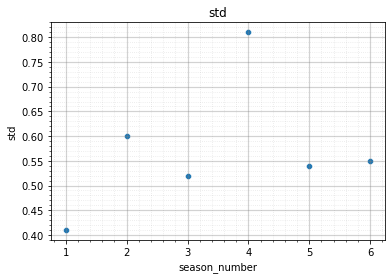

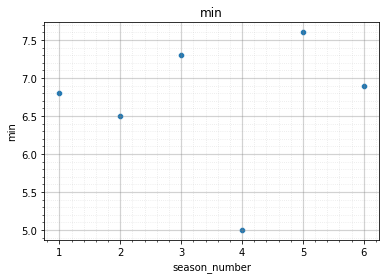

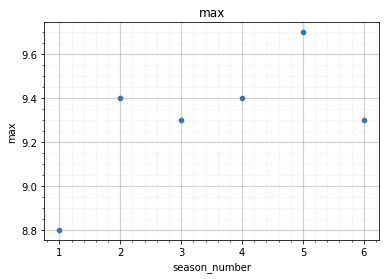

In [35]:
# tv series stats
# see average episode rating for each season
description_dataFrame = dataFrame.groupby("season_number")['episode_rating'].describe().round(2).drop(['25%','50%','75%'], axis=1)
# graphs
description_dataFrame = description_dataFrame.reset_index()
cols_list = description_dataFrame.columns.tolist()
for i, x in enumerate(cols_list):
    sns.scatterplot(data=description_dataFrame, x='season_number', y=x)
    plt.gca().set_title(x)
    plt.gca().grid(b=True, which='major', color='grey', lw=1.2, alpha=0.35, zorder=1)
    plt.gca().grid(b=True, which='minor', color='grey', linestyle=':', alpha=0.2)
    plt.gca().minorticks_on()
    plt.show()

# creating a heatmap

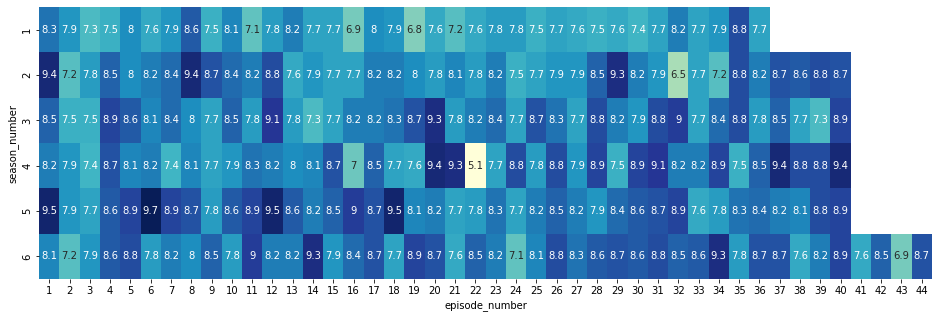

In [27]:
#heatmap
episode_performance_dataFrame = dataFrame.pivot('season_number','episode_number','episode_rating')
plt.figure(figsize=(16,5))
sns.heatmap(episode_performance_dataFrame, annot=True, cmap="YlGnBu", cbar=False);

# a basic scatterplot

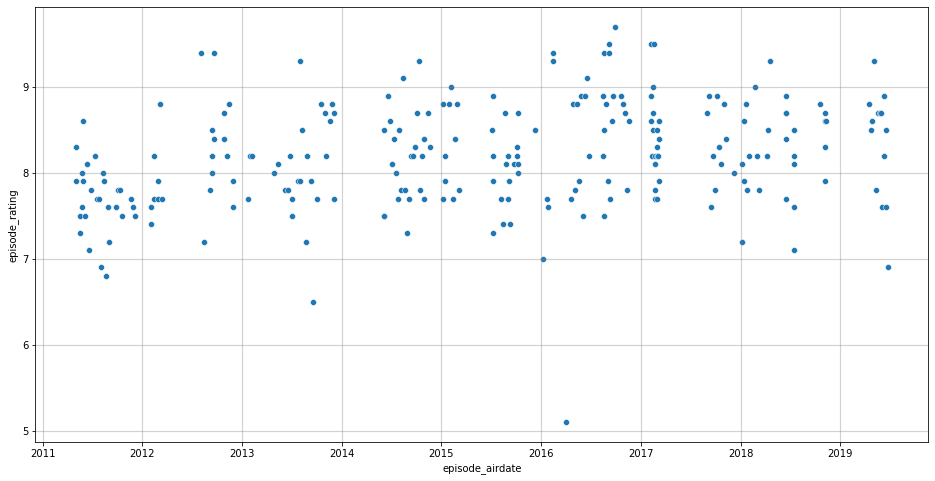

In [48]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=dataFrame, x='episode_airdate',y='episode_rating')
plt.grid(b=True, which='major', c='grey', alpha=0.35, lw=1.2)

# scatterplot including cutoffs for each season

(3.5, 10.0)

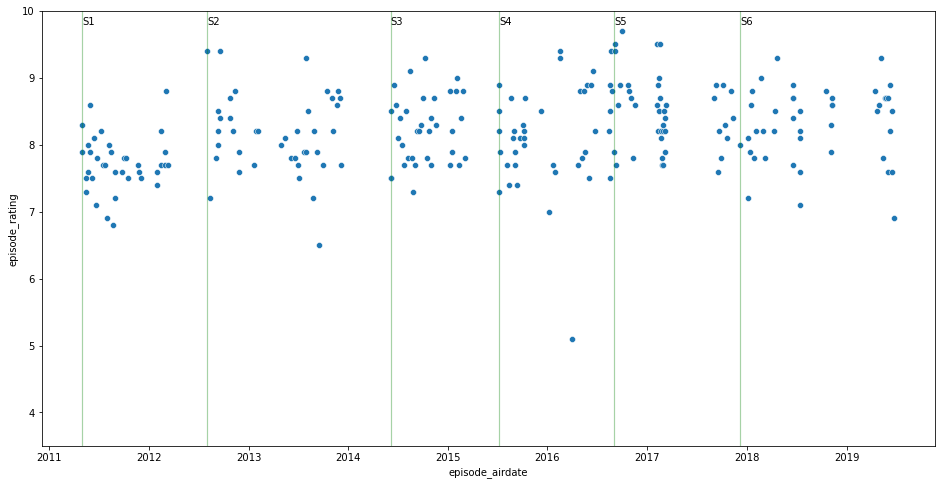

In [53]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=dataFrame, x='episode_airdate', y='episode_rating', ax=ax)

season_start_dates = dataFrame.groupby('season_number')['episode_airdate'].min().tolist()

for season, season_start in enumerate(season_start_dates):
    ax.axvline(season_start, lw=1.2, c='green', alpha=0.35) #vertical line indicates when new season starts
    ax.text(x=season_start, y=9.8, s=f'S{season + 1}') # text on graph that accompanies vertical line^

ax.set_ylim(3.5, 10)


# scatterplot with line indicating average episode rating

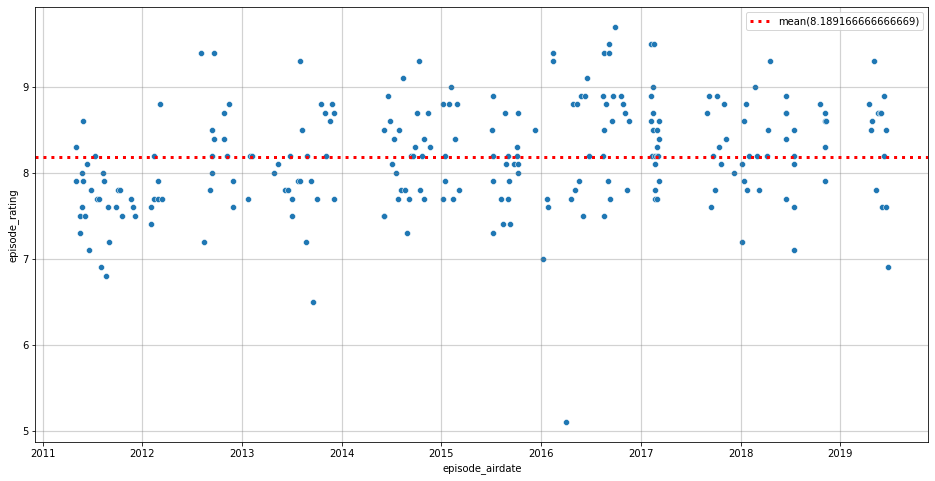

In [50]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=dataFrame, x='episode_airdate',y='episode_rating')

mean = dataFrame['episode_rating'].mean()
plt.axhline(y=mean, label=f'mean({mean})', ls=':', c='red', lw=3) #axhline gives a horizontal line

plt.legend()

plt.grid(b=True, which='major', c='grey', alpha=0.35, lw=1.2)
# can also include season start lines (from above) if wanted

# line of regression - indicates extent of changes?

(0.0, 240.0)

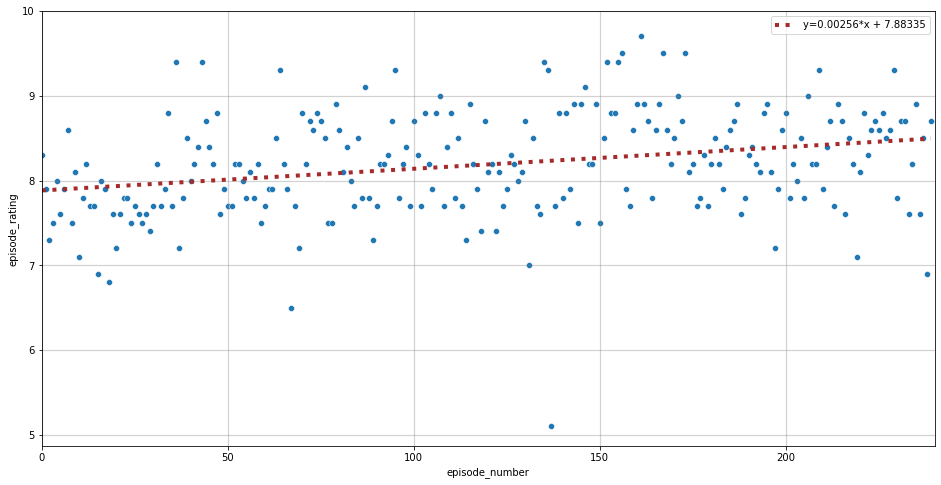

In [59]:
# scatterPlot of with line of regression comparing episode ratings and episode numbers
fig, ax = plt.subplots(figsize=(16, 8))

dataFrame['episode_number'] = range(len(dataFrame))

sns.scatterplot(data=dataFrame, x='episode_number', y='episode_rating', ax=ax)

# gridlines
ax.grid(b=True, which='major', color='grey', lw=1.2, alpha=0.35, zorder=1)


# line of regression
x = dataFrame['episode_number']
y = dataFrame['episode_rating']

m, b = np.polyfit(x, y, 1)
formula = f'y={round(m, 5)}*x + {round(b, 5)}' # round to 5 decimal places

plt.plot(x, m * x + b, ls=':', lw=4, c='brown', label=formula)
ax.legend()

ax.set_ylim(top=10)
ax.set_xlim(0, len(dataFrame))

In [16]:
text = " ".join(dataFrame['episode_description'].tolist())

In [34]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

text_tokens = word_tokenize(text)
tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
print(tokens_without_sw)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mykas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\mykas/nltk_data'
    - 'C:\\Users\\mykas\\anaconda3\\nltk_data'
    - 'C:\\Users\\mykas\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\mykas\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\mykas\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************
